In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import os, sys
cwd = os.getcwd()

api_path_toy = os.path.join(cwd, '..', 'tools', 'toy_examples_utils')
#api_path_sir = os.path.join(cwd, '..', 'tools', 'sir_ais_sampling')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_toy)
#sys.path.append(api_path_sir)
sys.path.append(os.path.join(cwd, '..', 'tools', 'sampling_utils'))

In [55]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from toy_examples_utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_real_data, 
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           mh_sampling_normal_proposal_plot_2d,
                           sir_correlated_plot_2d,
                           sir_independent_plot_2d,
                           #xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from mh_sampling import mh_sampling, mh_sampling_from_scratch
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          mh_sampling_normal_proposal,
                          #xtry_langevin_sampling,
                          gan_energy)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from general_utils import DotDict

from metrics import Evolution

In [4]:
from pathlib import Path
figpath = Path('../figs')

# 2D Gaussians, true distribution

In [5]:
sigma

0.05

In [6]:
train_dataset_size

64000

In [69]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

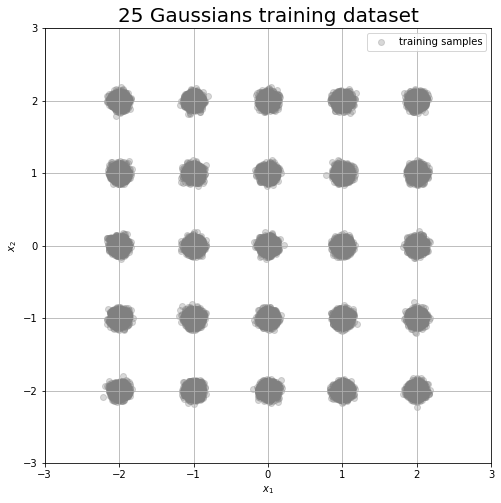

In [70]:
title = '25 Gaussians training dataset'
path_to_save = Path(figpath, '25_gaussians_training.pdf')
plot_real_data(X_train, title, path_to_save)

In [71]:
n_dim = 2
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob


n_dim = 2
loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [72]:
evols = dict()

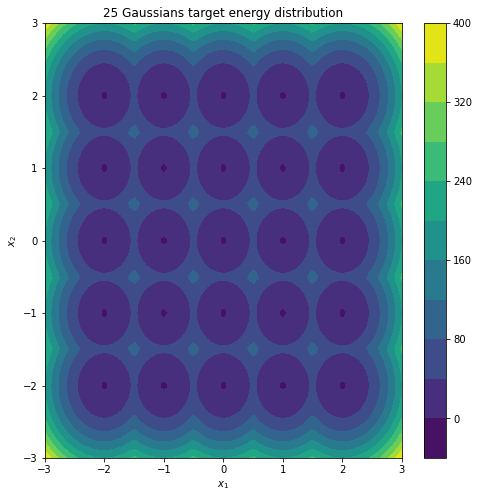

In [73]:
true_target_energy = Gaussian_mixture(target_args).energy

x_range = 3.0
y_range = 3.0
title = '25 Gaussians target energy distribution'
path_to_save = Path(figpath, '25_gaussians_energy.pdf')
plot_potential_energy(true_target_energy,
                      x_range,
                      y_range,
                      device,
                      path_to_save = path_to_save,
                      num_points = 100,
                      title = title)

In [8]:
batch_size_sample = 5000

In [74]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 50
n_batches = 10
batch_size_sample = 10000
langevin_sampling_plot_2d(true_target,
                          proposal,
                          X_train,  
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches,
                          path_to_save=Path(figpath, '2d_known_target_ula.pdf'))

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


In [14]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5
n_steps = 500
every = 50
z_last_np, zs = langevin_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)

zs = zs[0, ::every]
Xs_gen = zs

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols['ULA'] = evol

100%|██████████| 1/1 [00:15<00:00, 15.04s/it]


In [182]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
#eps_scale = 1e-2
n_steps = 100
n_batches = 10
acceptance_rule = 'Hastings'
mala_sampling_plot_2d(true_target,
                      proposal,
                      X_train,  
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      path_to_save=Path(figpath, '2d_known_target_mala_hastings.pdf'))

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


In [22]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5
n_steps = 500
every = 50

z_last_np, zs = mala_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               acceptance_rule = 'Hastings')

zs = zs[0, ::every]
Xs_gen = zs

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'MALA, MH'] = evol

100%|██████████| 1/1 [00:29<00:00, 29.99s/it]


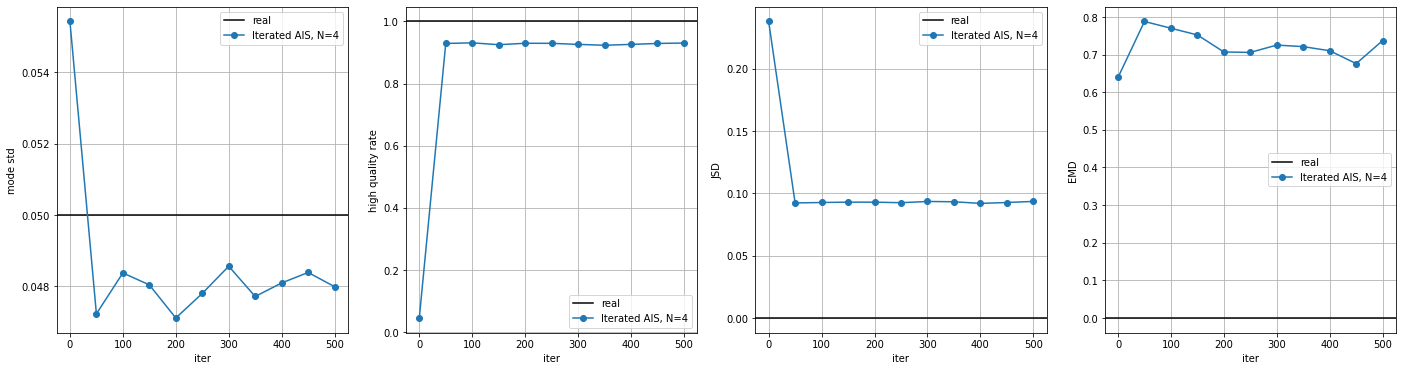

In [10]:
plot_chain_metrics(**evols)

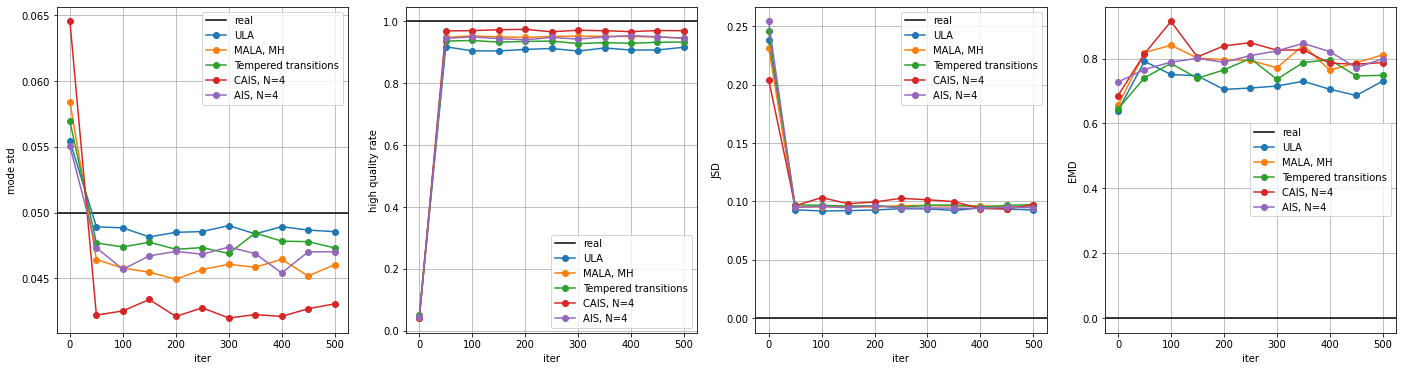

In [32]:
plot_chain_metrics(**evols, savepath=Path(figpath, '2d_known_target_chains_metrics.pdf'))

In [188]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Barker'
mala_sampling_plot_2d(true_target,
                      proposal,
                      X_train,  
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      path_to_save=Path(figpath, '2d_known_target_mala_barker.pdf'))

100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


# 2D Gaussians, GANs

In [7]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [8]:
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [9]:
discriminator_regexp = os.path.join(models_2d_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_2d_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [10]:
G.load_state_dict(torch.load(generator_name, map_location=device))
D.load_state_dict(torch.load(discriminator_name, map_location=device))

<All keys matched successfully>

In [11]:
G = G.to(device)
D = D.to(device)
G.z_dim = G.n_dim

In [12]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

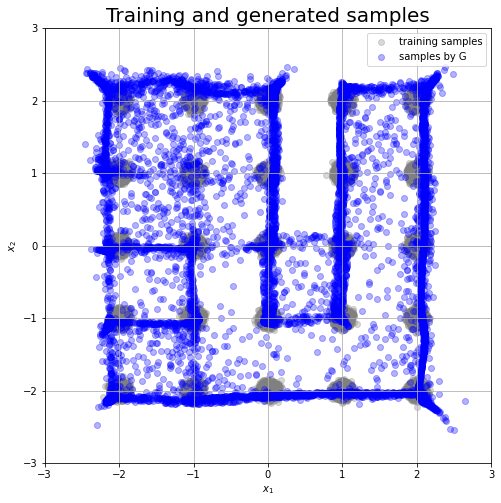

In [13]:
batch_size_sample = 10000
x_range = 3.0
y_range = 3.0
#path_to_final_save = Path(figpath, '25_gaussians_gan_samples.pdf')
#path_to_save = figpath
path_to_final_save = None
path_to_save = None
sample_fake_data(G, X_train,  
                 x_range,
                 y_range,
                 scaler = scaler,
                 path_to_save = path_to_save,
                 path_to_final_save = path_to_final_save,
                 batch_size_sample = batch_size_sample)

In [12]:
x_range = 3.0
y_range = 3.0
plot_discriminator_2d(D,
                      x_range,
                      y_range,
                      scaler = scaler,
                      num_points = 700,
                      path_to_save=Path(figpath, '2d_gan_discriminator.pdf'))

In [15]:
n_calib_pts = 10000
type_calibrator = 'isotonic'
normalize_to_0_1 = False
n_steps = 500
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_steps = n_steps,
                    n_calib_pts = n_calib_pts,
                    scaler = scaler, 
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1,
                    path_to_save=Path(figpath, '2d_gan_mhgan_isotonic.pdf'))

  0%|          | 9/10000 [00:00<01:57, 85.33it/s]

Start to do MH sampling....
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6fb7de8e0>}
start to train calibrator


100%|██████████| 10000/10000 [01:55<00:00, 86.32it/s]


In [16]:
n_calib_pts = 10000
type_calibrator = 'linear'
normalize_to_0_1 = False
n_steps = 500
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_steps = n_steps,
                    n_calib_pts = n_calib_pts,
                    scaler = scaler, 
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1,
                    path_to_save=Path(figpath, '2d_gan_mhgan_linear.pdf'))

  0%|          | 13/10000 [00:00<01:17, 129.47it/s]

Start to do MH sampling....
Used calibrator: 
{'linear': <classification.Linear object at 0x7fb6fb7e5f70>}
start to train calibrator


100%|██████████| 10000/10000 [01:19<00:00, 125.27it/s]


  0%|          | 10/10000 [00:00<01:48, 91.67it/s]

Start to do MH sampling....


100%|██████████| 10000/10000 [01:52<00:00, 88.58it/s]


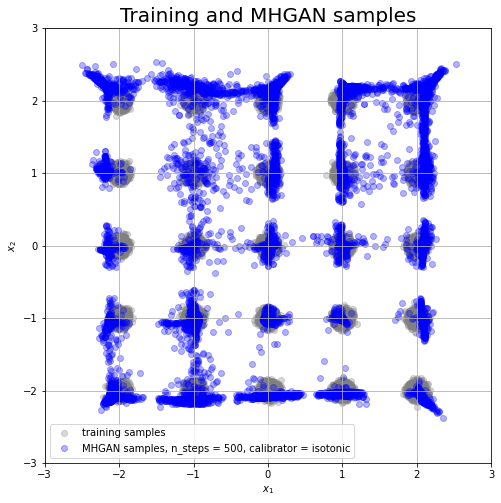

In [26]:
n_calib_pts = 10000
type_calibrator = 'isotonic'
normalize_to_0_1 = False
n_steps = 500
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_steps = n_steps,
                    n_calib_pts = n_calib_pts,
                    scaler = scaler, 
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1)

  0%|          | 9/10000 [00:00<01:52, 89.04it/s]

Start to do MH sampling....
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb81342db80>}
start to train calibrator


100%|██████████| 10000/10000 [01:57<00:00, 85.07it/s]


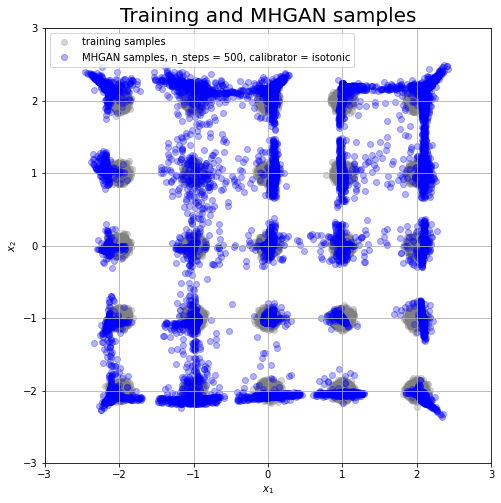

In [14]:
n_calib_pts = 10000
type_calibrator = 'isotonic'
normalize_to_0_1 = False
n_steps = 500
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_steps = n_steps,
                    n_calib_pts = n_calib_pts,
                    scaler = scaler, 
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1)

  0%|          | 12/10000 [00:00<01:23, 119.24it/s]

Start to do MH sampling....
Used calibrator: 
{'linear': <classification.Linear object at 0x7fb761d80880>}
start to train calibrator


100%|██████████| 10000/10000 [01:18<00:00, 127.55it/s]


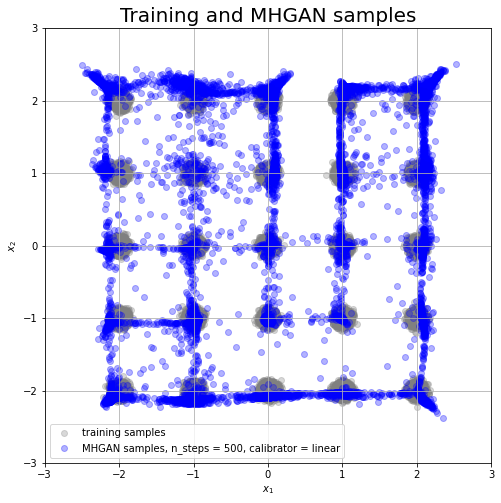

In [13]:
n_calib_pts = 10000
type_calibrator = 'linear'
normalize_to_0_1 = False
n_steps = 500
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_steps = n_steps,
                    n_calib_pts = n_calib_pts,
                    scaler = scaler, 
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1)

In [21]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normalize_to_0_1 = True 
log_prob = True

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

target_gan = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [22]:
evols = dict()

100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


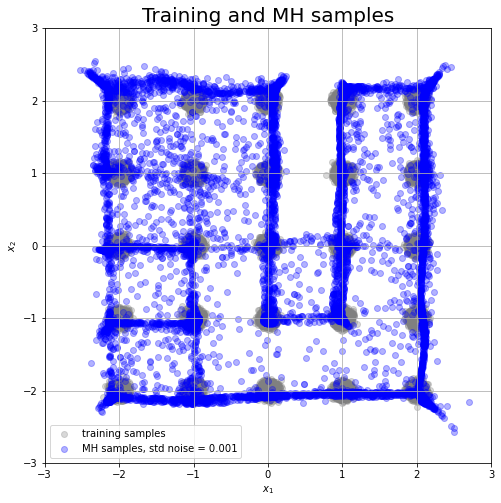

In [27]:
eps_scale = 1e-3
n_steps = 1000
n_batches = 10
acceptance_rule = 'Hastings'
mh_sampling_normal_proposal_plot_2d(target_gan,
                                    proposal,
                                    X_train,  
                                    path_to_save = None,
                                    scaler = scaler, 
                                    batch_size_sample = batch_size_sample,
                                    eps_scale = eps_scale,
                                    n_steps = n_steps,
                                    acceptance_rule = acceptance_rule,
                                    n_batches = n_batches,
                                    latent_transform = G)

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


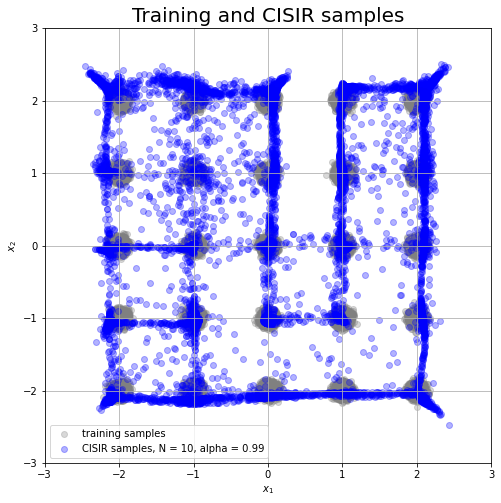

In [36]:
N = 10
alpha = 0.99
n_steps = 1000
n_batches = 10
sir_correlated_plot_2d(target_gan,
                       proposal,
                       X_train,  
                       path_to_save = None,
                       scaler = scaler, 
                       batch_size_sample = batch_size_sample,
                       N = N,
                       n_steps = n_steps,
                       alpha = alpha,
                       n_batches = n_batches,
                       latent_transform = G)

100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


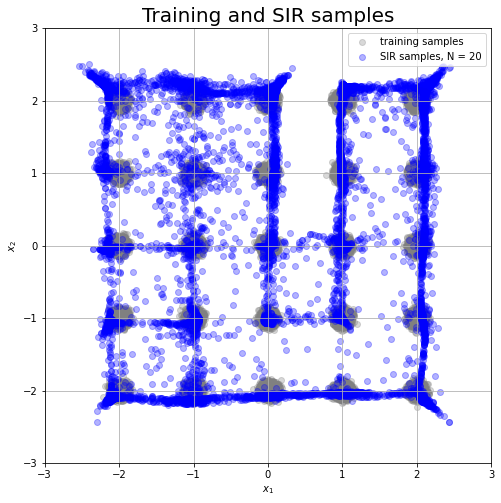

In [39]:
N = 20
n_steps = 1000
n_batches = 10
sir_independent_plot_2d(target_gan,
                        proposal,
                        X_train,  
                        path_to_save = None,
                        scaler = scaler, 
                        batch_size_sample = batch_size_sample,
                        N = N,
                        n_steps = n_steps,
                        n_batches = n_batches,
                        latent_transform = G)

In [54]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 100
n_batches = 10
langevin_sampling_plot_2d(target_gan,
                          proposal,
                          X_train,  
                          scaler = scaler, 
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches,
                          latent_transform = G,
                          path_to_save=Path(figpath, '2d_gan_ula.pdf'))

100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


In [19]:
n_dim = 2
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob


n_dim = 2
loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [56]:
evols = dict()

In [65]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

q = 0.999
evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler,
                      q=q)

n_steps = 1000
every = 50
grad_step = 1e-3
eps_scale = 1e-2 #(grad_step * 2) ** 0.5 #1e-1
z_last_np, zs = langevin_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)#,
                               #n_batches = n_batches)

zs = zs[0, ::every]

Xs_gen = G(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen).to(device))
evol = evolution.as_dict()
evols['ULA'] = evol

100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:230: RuntimeWarning: invalid value encountered in multiply
  kl = np.mean(kl).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in subtract
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:230: RuntimeWarning: invalid value encountered in multiply
  kl = np.mean(kl).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value en

/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:230: RuntimeWarning: invalid value encountered in multiply
  kl = np.mean(kl).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in subtract
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:230: RuntimeWarning: invalid value encountered in multiply
  kl = np.mean(kl).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in subtract
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item(

In [74]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

q = 0.999
evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler,
                      q=q)

n_steps = 1000
every = 50

grad_step = 1e-3
eps_scale = 1e-2

z_last_np, zs = mala_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               acceptance_rule = 'Hastings')#,
                               #n_batches = n_batches)

zs = zs[0, ::every]
Xs_gen = zs

Xs_gen = G(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen).to(device))
evol = evolution.as_dict()
evols[f'MALA, MH'] = evol

100%|██████████| 1/1 [00:03<00:00,  3.61s/it]
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value en

In [73]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]
q = 0.999
evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler,
                      q = q)

n_steps = 1000
every = 50

grad_step = 1e-3
eps_scale = 1e-2

z_last_np, zs = mala_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               acceptance_rule = 'Barker')#,
                               #n_batches = n_batches)

zs = zs[0, ::every]
Xs_gen = zs

Xs_gen = G(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen).to(device))
evol = evolution.as_dict()
evols[f'MALA, Barker'] = evol

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value en

In [98]:
n_calib_pts = 10000
type_calibrator = 'isotonic'
normalize_to_0_1 = False
n_steps = 500
every = 50

if scaler is not None:
    X_train_scale = scaler.transform(X_train)
else:
    X_train_scale = X_train

zs = []
num_steps = [1] + [(i + 1)*every for i in range(20)]
for num_step in num_steps:
    print(f"num step = {num_step}")
    X_mh = mh_sampling_from_scratch(X_train_scale,
                                    G,
                                    D,
                                    G.device,
                                    n_calib_pts,
                                    batch_size_sample=batch_size_sample,
                                    n_steps=num_step,
                                    type_calibrator=type_calibrator,
                                    normalize_to_0_1=normalize_to_0_1)
    zs.append(X_mh)

  0%|          | 32/10000 [00:00<00:31, 317.50it/s]

num step = 1
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6faca16a0>}
start to train calibrator


  0%|          | 27/10000 [00:00<00:38, 260.37it/s]

num step = 50
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f68557c0>}
start to train calibrator


  0%|          | 22/10000 [00:00<00:47, 211.10it/s]

num step = 100
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f6887c70>}
start to train calibrator


 11%|█         | 1101/10000 [00:05<00:43, 206.81it/s]/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/mh.py:77: RuntimeWarning: invalid value encountered in double_scalars
  alpha = ((1.0 / P_disc_last) - 1.0) / ((1.0 / P_disc_new) - 1.0)
  0%|          | 18/10000 [00:00<00:55, 179.20it/s]

num step = 150
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb7002ffbe0>}
start to train calibrator


  0%|          | 16/10000 [00:00<01:02, 158.80it/s]

num step = 200
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6fac8bdc0>}
start to train calibrator


  0%|          | 14/10000 [00:00<01:16, 130.43it/s]

num step = 250
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f66627f0>}
start to train calibrator


  0%|          | 13/10000 [00:00<01:21, 123.26it/s]

num step = 300
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb7002e7280>}
start to train calibrator


  0%|          | 12/10000 [00:00<01:27, 114.14it/s]

num step = 350
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f66aaf70>}
start to train calibrator


  0%|          | 11/10000 [00:00<01:37, 102.24it/s]

num step = 400
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f66ab850>}
start to train calibrator


 32%|███▏      | 3199/10000 [00:31<01:05, 104.01it/s]/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/mh.py:77: RuntimeWarning: invalid value encountered in double_scalars
  alpha = ((1.0 / P_disc_last) - 1.0) / ((1.0 / P_disc_new) - 1.0)
 66%|██████▌   | 6597/10000 [01:04<00:32, 103.93it/s]/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/mh.py:77: RuntimeWarning: invalid value encountered in double_scalars
  alpha = ((1.0 / P_disc_last) - 1.0) / ((1.0 / P_disc_new) - 1.0)
  0%|          | 10/10000 [00:00<01:49, 91.29it/s]

num step = 450
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb761df4b20>}
start to train calibrator


 78%|███████▊  | 7790/10000 [01:26<00:24, 89.85it/s]/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/mh.py:77: RuntimeWarning: invalid value encountered in double_scalars
  alpha = ((1.0 / P_disc_last) - 1.0) / ((1.0 / P_disc_new) - 1.0)
  0%|          | 9/10000 [00:00<01:56, 85.93it/s]

num step = 500
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6fbded580>}
start to train calibrator


  0%|          | 9/10000 [00:00<02:04, 80.24it/s]

num step = 550
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f66debe0>}
start to train calibrator


  0%|          | 8/10000 [00:00<02:14, 74.12it/s]

num step = 600
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb7002b0d00>}
start to train calibrator


  0%|          | 8/10000 [00:00<02:19, 71.61it/s]

num step = 650
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb761dfa940>}
start to train calibrator


  0%|          | 7/10000 [00:00<02:37, 63.61it/s]

num step = 700
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f43b6be0>}
start to train calibrator


  0%|          | 7/10000 [00:00<02:35, 64.14it/s]

num step = 750
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb761d7d670>}
start to train calibrator


  0%|          | 7/10000 [00:00<02:43, 61.05it/s]

num step = 800
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb6f666c430>}
start to train calibrator


  0%|          | 6/10000 [00:00<02:49, 58.86it/s]

num step = 850
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb761d0f2b0>}
start to train calibrator


  0%|          | 6/10000 [00:00<03:06, 53.64it/s]

num step = 900
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb761d80fd0>}
start to train calibrator


  0%|          | 6/10000 [00:00<03:17, 50.52it/s]

num step = 950
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb813582e20>}
start to train calibrator


  0%|          | 6/10000 [00:00<03:12, 51.93it/s]

num step = 1000
Used calibrator: 
{'isotonic': <classification.Isotonic object at 0x7fb774222d90>}
start to train calibrator


100%|██████████| 10000/10000 [03:22<00:00, 49.43it/s]


In [104]:
zs[0].shape

(10000, 2)

In [105]:
zs_concat = np.array(zs)
print(zs_concat.shape)

(21, 10000, 2)


In [14]:
evols = dict()


In [121]:
path_to_save_mhgan_res = '/home/daniil/gans-mcmc/saved_numpy_arrays/mhgan_isotonic.np'
np.save(path_to_save_mhgan_res, zs_concat)

In [26]:
path_to_save_mhgan_res = '/home/daniil/gans-mcmc/saved_numpy_arrays/mhgan_isotonic.np.npy'
zs_concat = np.load(path_to_save_mhgan_res)

In [68]:
Xs_gen = zs_concat
type_calibrator = 'isotonic'
q = 0.999
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)

#Xs_gen = G(torch.FloatTensor(zs_concat).to(device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen).to(device))
evol = evolution.as_dict()
evols[f'MHGAN, calibrator = {type_calibrator}'] = evol

/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item()
/home/daniil/gans-mcmc/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:236: RuntimeWarning: invalid value encountered in multiply
  js = np.mean(js).item(

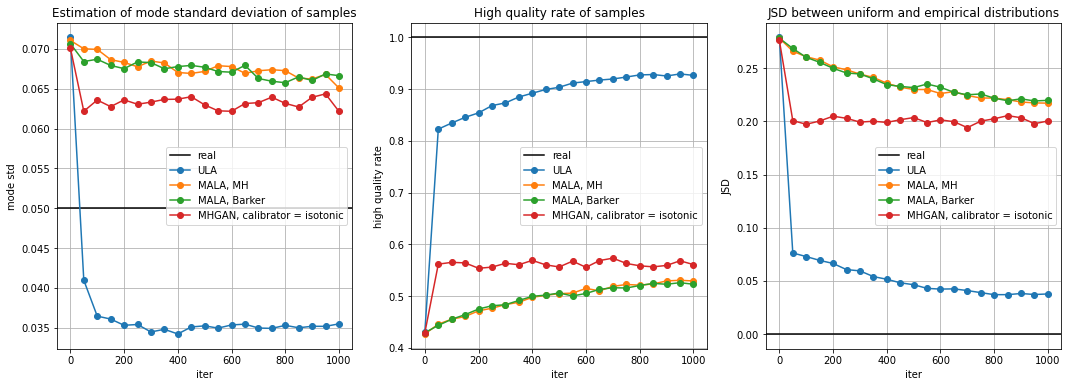

In [75]:
plot_chain_metrics(**evols, savepath=Path(figpath, '2d_gan_chain_metrics.pdf'))




In [77]:
evols["MHGAN, calibrator = isotonic"]

{'mode_std': [0.07009492069482803,
  0.062164921313524246,
  0.06357231736183167,
  0.06274627894163132,
  0.06359425187110901,
  0.0630430057644844,
  0.06330981850624084,
  0.06365080922842026,
  0.06368046998977661,
  0.06398769468069077,
  0.06296567618846893,
  0.062218077480793,
  0.06216233968734741,
  0.06313442438840866,
  0.06324294954538345,
  0.0639321580529213,
  0.06315557658672333,
  0.06269945949316025,
  0.0639171302318573,
  0.06434591859579086,
  0.06215231865644455],
 'hqr': [0.4293999969959259,
  0.5616999864578247,
  0.5651999711990356,
  0.5640999674797058,
  0.5536999702453613,
  0.5559999942779541,
  0.5633000135421753,
  0.5605999827384949,
  0.5690000057220459,
  0.5602999925613403,
  0.5562999844551086,
  0.5674999952316284,
  0.5555999875068665,
  0.5685999989509583,
  0.5733000040054321,
  0.5630999803543091,
  0.5584999918937683,
  0.5564999580383301,
  0.5591999888420105,
  0.5681999921798706,
  0.5608999729156494],
 'jsd': [0.2760806977748871,
  0.20070

In [63]:
from scipy.stats import chi2, entropy
chi2_quantile = chi2.ppf(0.999, 2)

In [64]:
chi2_quantile ** 0.5

3.7169221888498383

In [28]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 500
n_batches = 10
acceptance_rule = 'Barker'
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      latent_transform = G,
                      path_to_save=Path(figpath, '2d_gan_mala_barker.pdf'))

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


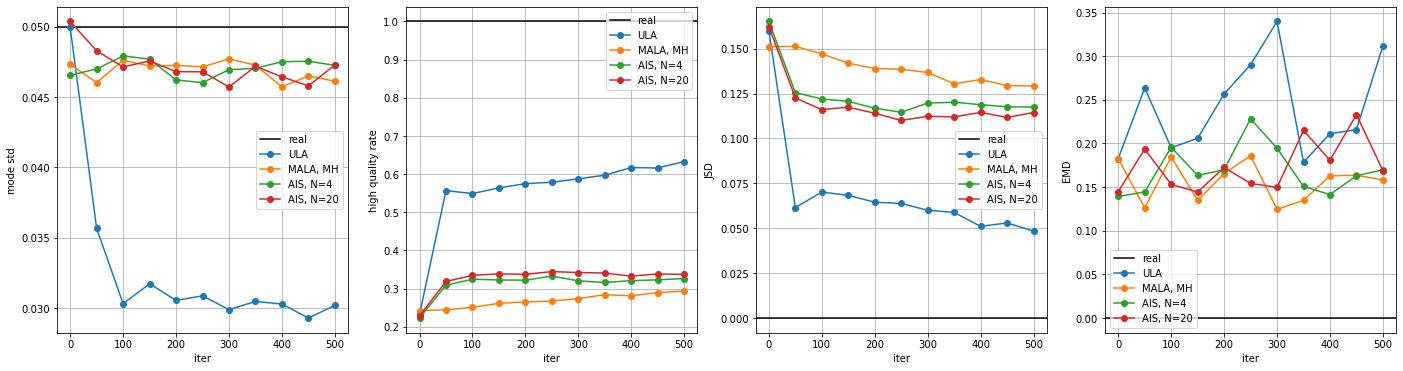

In [35]:
plot_chain_metrics(**evols, savepath=Path(figpath, '2d_gan_chain_metrics.pdf'))

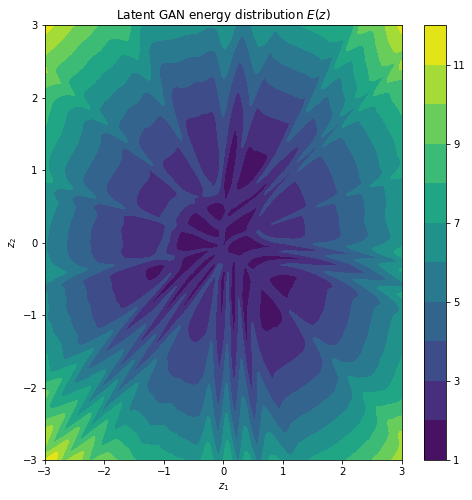

In [79]:
log_prob = False
target_gan_energy = partial(gan_energy, 
                            generator = G, 
                            discriminator = D, 
                            proposal = proposal,
                            normalize_to_0_1 = normalize_to_0_1,
                            log_prob = log_prob)
x_range = 3.0
y_range = 3.0
norm_grads = False
title = r'Latent GAN energy distribution $E(z)$'
path_to_save = Path(figpath, 'latent_gan_energy.pdf')
mode_visual = 'latent'
plot_potential_energy(target_gan_energy,
                      x_range,
                      y_range,
                      device,
                      path_to_save = path_to_save,
                      norm_grads = norm_grads,
                      num_points = 700,
                      title = title,
                      mode_visual = mode_visual)

In [60]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 100
n_batches = 10
batchsize = batch_size_sample // n_batches
X_langevin, zs = langevin_sampling(target_gan, proposal, batchsize, batch_size_sample, 
                                       None, None, None, None, 
                                       n_steps, grad_step, eps_scale)

100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


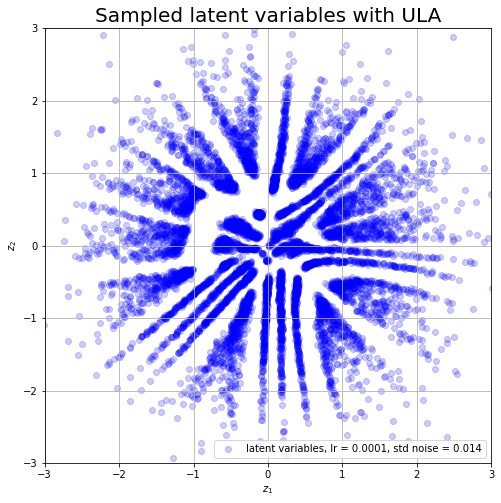

In [78]:
path_to_save = Path(figpath, 'latent_variables_ula.pdf')
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Sampled latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(X_langevin[:,:1], X_langevin[:,1:], alpha=0.2, color='blue', 
            marker='o', label = f'latent variables, lr = {grad_step}, std noise = {round(eps_scale, 3)}')
plt.grid(True)
plt.xlabel(r"$z_{1}$")
plt.ylabel(r"$z_{2}$")
plt.legend()
plt.savefig(path_to_save)
plt.show()